# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [45]:
# Import libraries
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, LSTM, GRU, Dropout
from keras.optimizers import Adam

import tensorflow as tf

!pip install keras_tuner
import keras_tuner as kt

### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [46]:
# Define a function to load data and aggregate them
def load_and_aggregate_csv(files_path):
  all_data = []
  try:
    file_names = os.listdir(files_path)
    for file in file_names:
      if file.endswith(".csv"):
        file_path = os.path.join(files_path, file)
        try:
            df = pd.read_csv(file_path)
            all_data.append(df)
        except Exception as e:
          print(f"Error reading file {file}: {e}")
    if all_data:
      aggregated_df = pd.concat(all_data, ignore_index=True)
      return aggregated_df
  except FileNotFoundError:
    print(f"Error: Directory not found at {files_path}")
    return pd.DataFrame()
  except Exception as e:
    print(f"An unexpected error occurred: {e}")
    return pd.DataFrame()

In [47]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files
path = '/content/drive/MyDrive/Upgrad/RNN_Stock_Price_Prediction/RNN_Stocks_Data'
stock_data = load_and_aggregate_csv(path)
stock_data.shape

(12077, 7)

In [48]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12077 entries, 0 to 12076
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    12077 non-null  object 
 1   Open    12076 non-null  float64
 2   High    12077 non-null  float64
 3   Low     12076 non-null  float64
 4   Close   12077 non-null  float64
 5   Volume  12077 non-null  int64  
 6   Name    12077 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 660.6+ KB


In [49]:
# View specifics of the data
stock_data["Name"].value_counts()

,count
Name,
IBM,3020
AMZN,3019
MSFT,3019
GOOGL,3019


#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [50]:
# Handle Missing Values

# check no of missing value in each col
no_of_missing_val_each_col = stock_data.isna().sum()
print(no_of_missing_val_each_col)

# remove the missing values from df
stock_data = stock_data.dropna()
stock_data.shape

Date      0
Open      1
High      0
Low       1
Close     0
Volume    0
Name      0
dtype: int64


(12076, 7)

### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

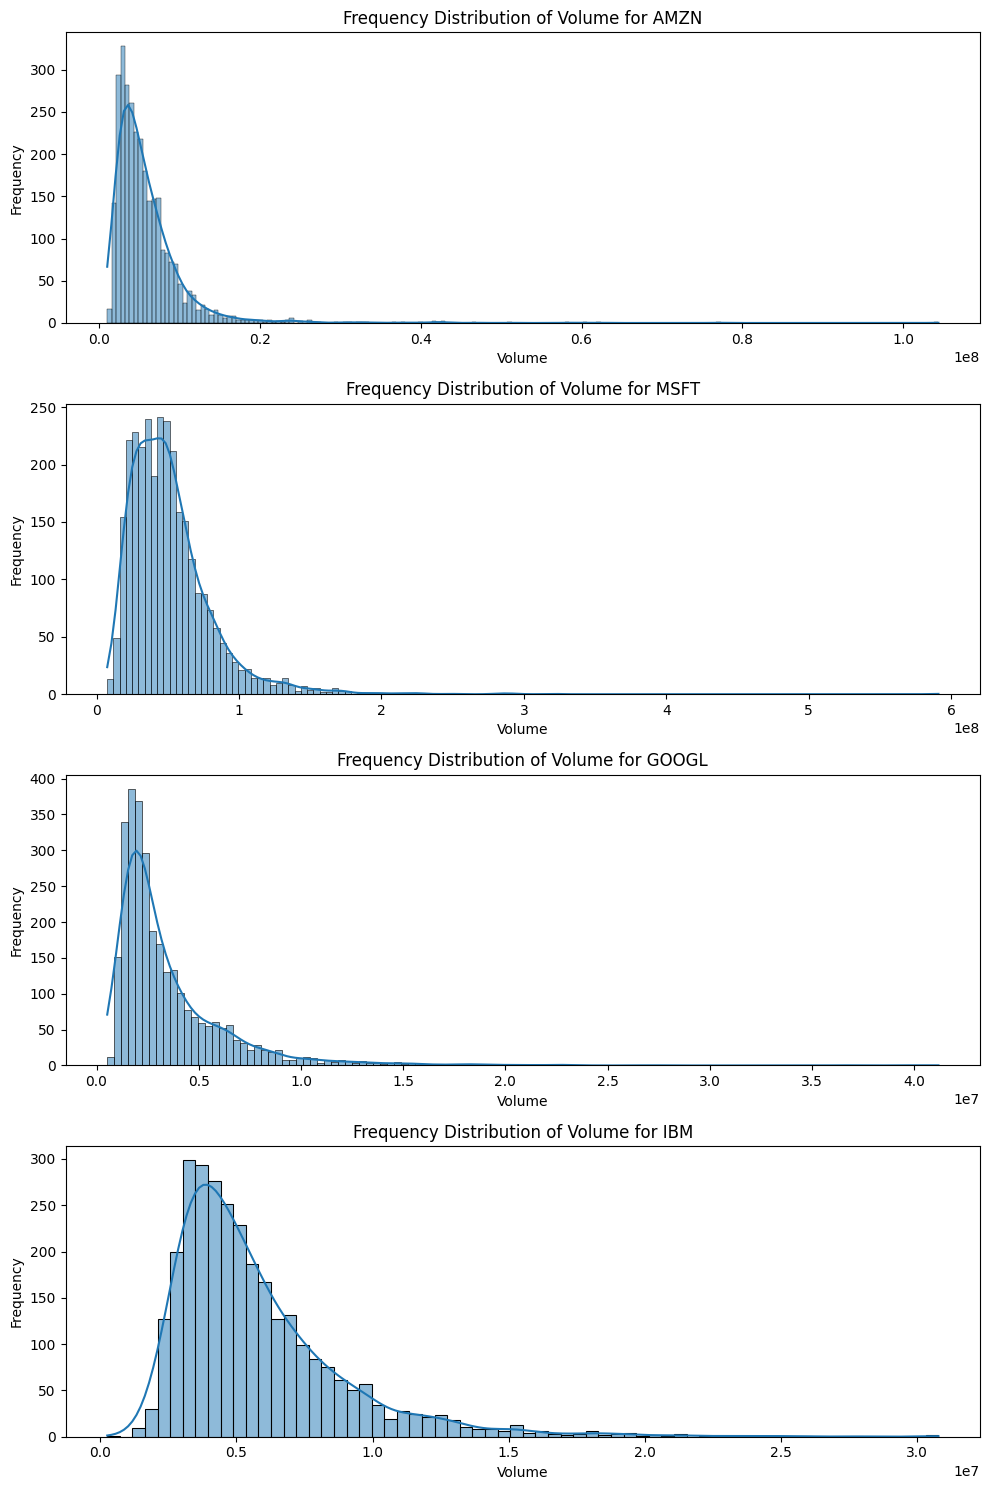

In [51]:
# Frequency distribution of volumes
fig, axes = plt.subplots(nrows=len(stock_data['Name'].unique()), ncols=1, figsize=(10, 15))

# Get the unique stock names
stock_names = stock_data['Name'].unique()

# Iterate through each stock name and create a histogram
for i, name in enumerate(stock_names):
    subset_data = stock_data[stock_data['Name'] == name]
    sns.histplot(data=subset_data, x='Volume', ax=axes[i], kde=True)
    axes[i].set_title(f'Frequency Distribution of Volume for {name}')
    axes[i].set_xlabel('Volume')
    axes[i].set_ylabel('Frequency')

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plots
plt.show()




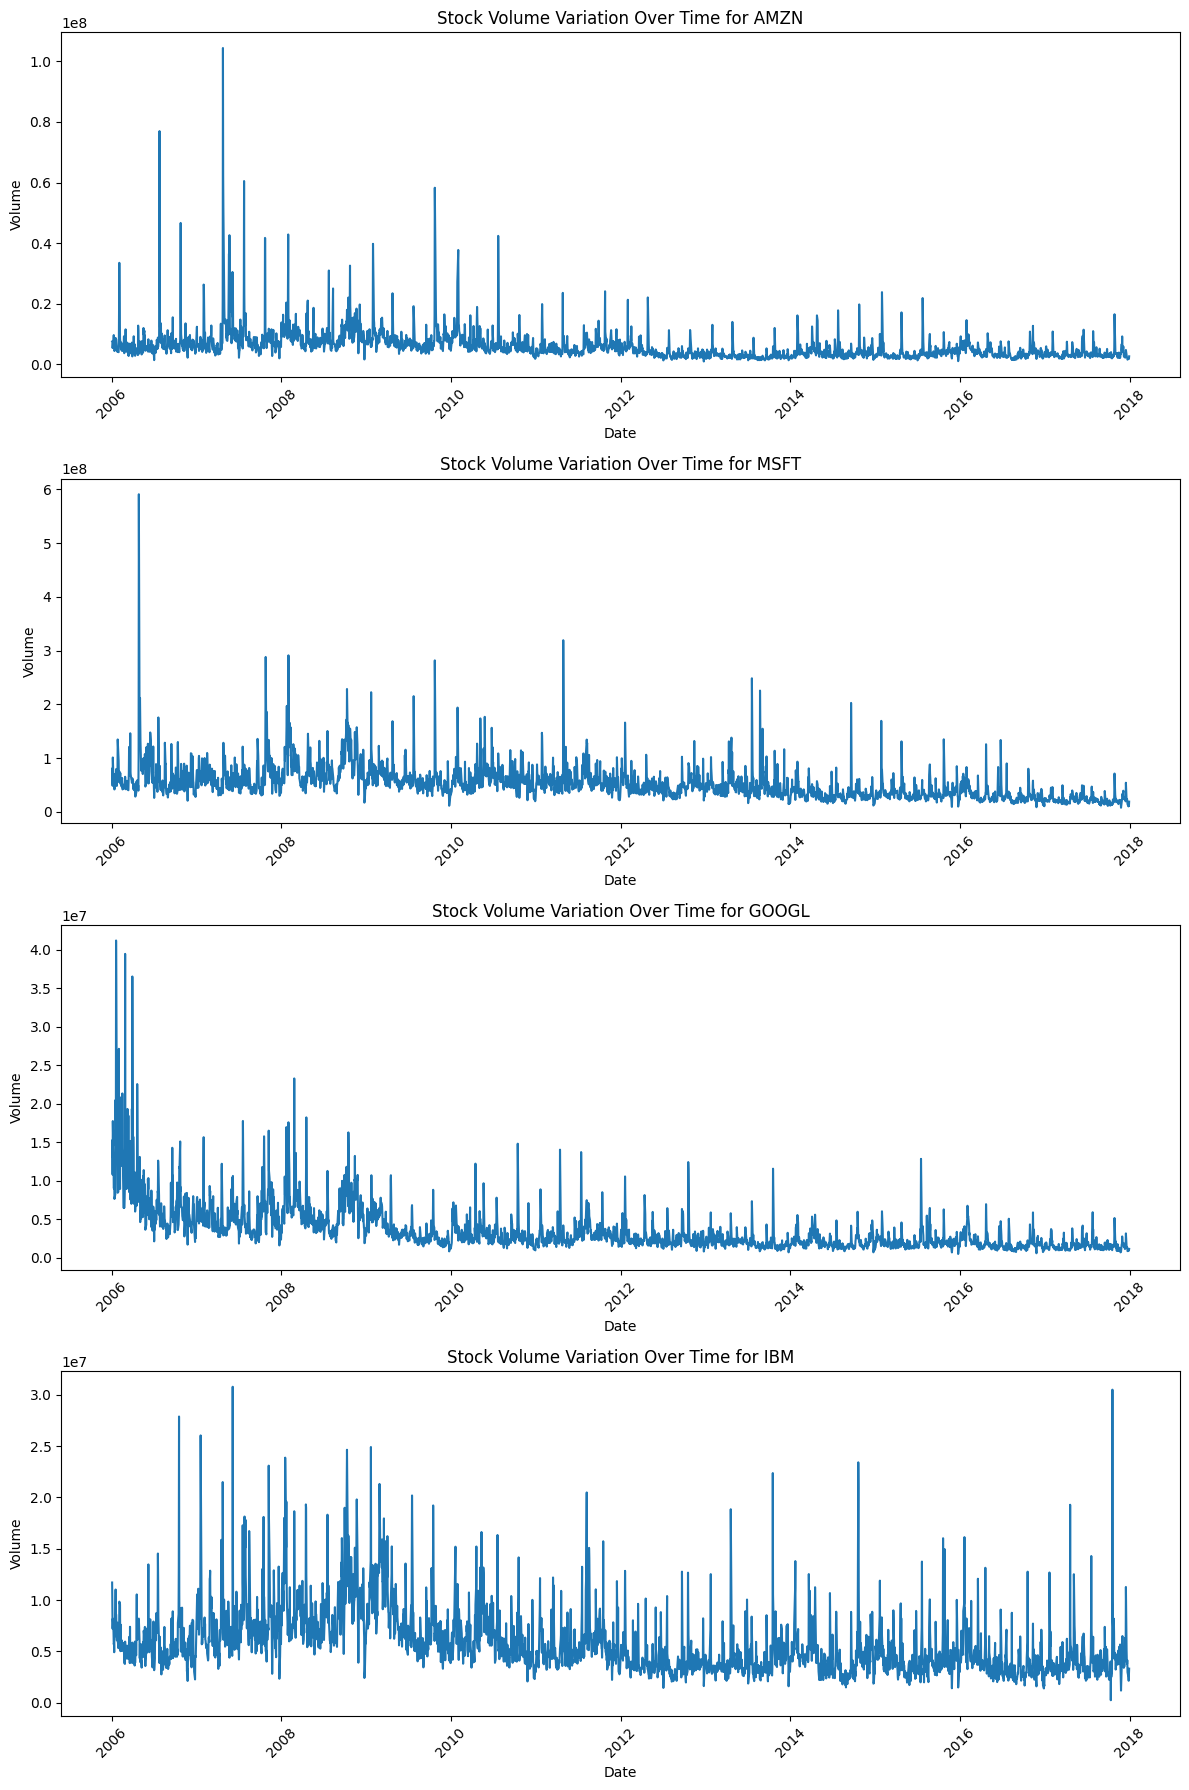

In [52]:
# Stock volume variation over time
# Ensure 'Date' column is in datetime format
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# Use a figure and axes to create subplots
fig, axes = plt.subplots(nrows=len(stock_data['Name'].unique()), ncols=1, figsize=(12, 18))

# Get the unique stock names
stock_names = stock_data['Name'].unique()

# Iterate through each stock name and create a line plot
for i, name in enumerate(stock_names):
    subset_data = stock_data[stock_data['Name'] == name].sort_values(by='Date') # Sort by date for proper plotting
    sns.lineplot(data=subset_data, x='Date', y='Volume', ax=axes[i])
    axes[i].set_title(f'Stock Volume Variation Over Time for {name}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Volume')
    axes[i].tick_params(axis='x', rotation=45) # Rotate x-axis labels for readability

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plots
plt.show()


#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

Correlation Matrix:
            Open      High       Low     Close    Volume
Open    1.000000  0.999945  0.999919  0.999873 -0.420741
High    0.999945  1.000000  0.999907  0.999935 -0.421103
Low     0.999919  0.999907  1.000000  0.999945 -0.420673
Close   0.999873  0.999935  0.999945  1.000000 -0.420895
Volume -0.420741 -0.421103 -0.420673 -0.420895  1.000000


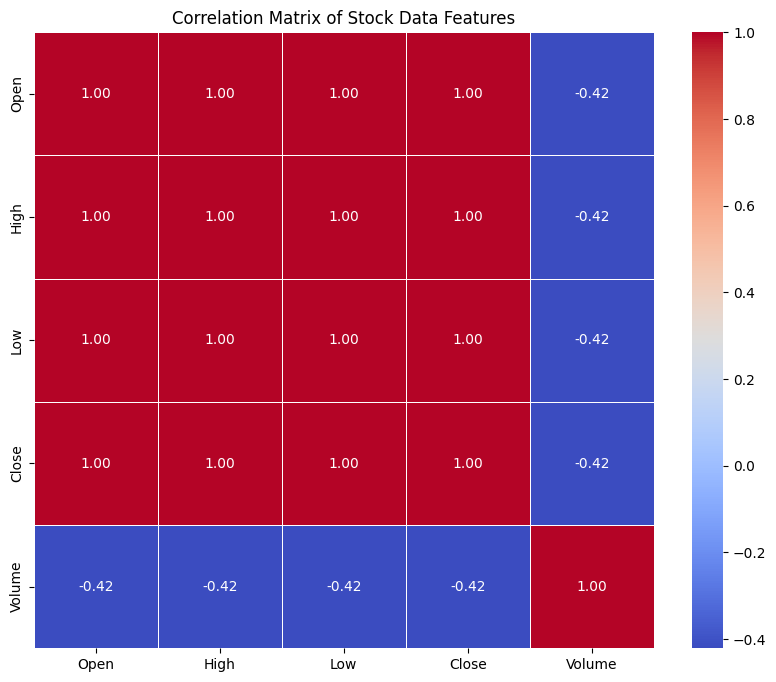

In [53]:
# Analyse correlations
# Select only the numerical columns for correlation analysis
numerical_cols = stock_data.select_dtypes(include=np.number).columns

# Calculate the correlation matrix
correlation_matrix = stock_data[numerical_cols].corr()

# Print the correlation matrix (optional)
print("Correlation Matrix:")
print(correlation_matrix)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Stock Data Features')
plt.show()

### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [54]:
# Define a function that divides the data into windows and generates target variable values for each window
def create_windows(data, feature_cols, target_cols, window_size, window_stride, target_names):
    X = []
    y = []

    # Ensure data is sorted by date before creating windows
    data = data.sort_values(by='Date')

    # features columns.
    feature_cols = feature_cols
    # Filter out columns not present in the data
    feature_cols = [col for col in feature_cols if col in data.columns]

    # Create target column names based on target_names
    target_cols = [f'{target_cols}' for name in target_names]

    # Iterate through the data to create windows
    # We iterate up to data.shape[0] - window_size to ensure we have a target value
    for i in range(0, data.shape[0] - window_size, window_stride):
      # Extract the input window (X)
      window_data = data.iloc[i : (i + window_size)][feature_cols].values
      X.append(window_data)

      # Extract the target value(s) (y)
      # The target is the 'Close' value for the specified stocks right after the window
      target_values = data.iloc[i + window_size][target_cols].values
      y.append(target_values)

    return np.array(X), np.array(y)


#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [55]:
# Define a function that scales the windowed data
# The function takes in the windowed data sets and returns the scaled windows
def scale_windows(X, y):
  n_samples, n_timesteps, n_features = X.shape
  X_reshaped = X.reshape(-1, n_features)

  scaler_X = MinMaxScaler(feature_range=(0, 1))
  X_scaled_reshaped = scaler_X.fit_transform(X_reshaped)
  X_scaled = X_scaled_reshaped.reshape(n_samples, n_timesteps, n_features)

  scaler_y = MinMaxScaler(feature_range=(0, 1))
  y_scaled = scaler_y.fit_transform(y)

  return X_scaled, y_scaled

Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [56]:
# Define a function to create input and output data points from the master DataFrame
def prepare_stock_data_for_rnn(data, input_config):
  feature_cols = input_config['feature_cols']
  target_cols = input_config['target_cols']
  target_names = input_config['target_names']
  window_size = input_config['window_size']
  stride = input_config['stride']
  test_size = input_config['test_size']
  random_state = input_config['random_state']

  X, y = create_windows(data, feature_cols, target_cols, window_size, stride, target_names)

  X_scaled, y_scaled = scale_windows(X, y)

  X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=test_size, shuffle=False, random_state=random_state)

  return X_train, y_train, X_test, y_test

We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

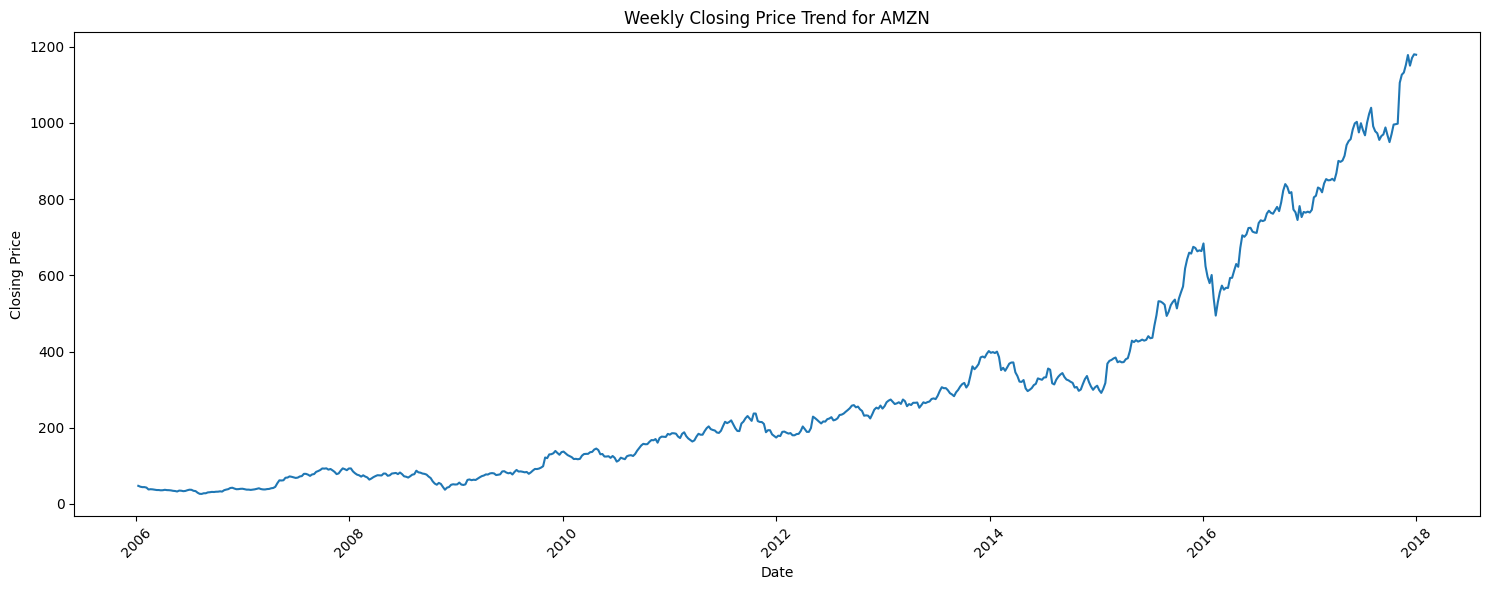

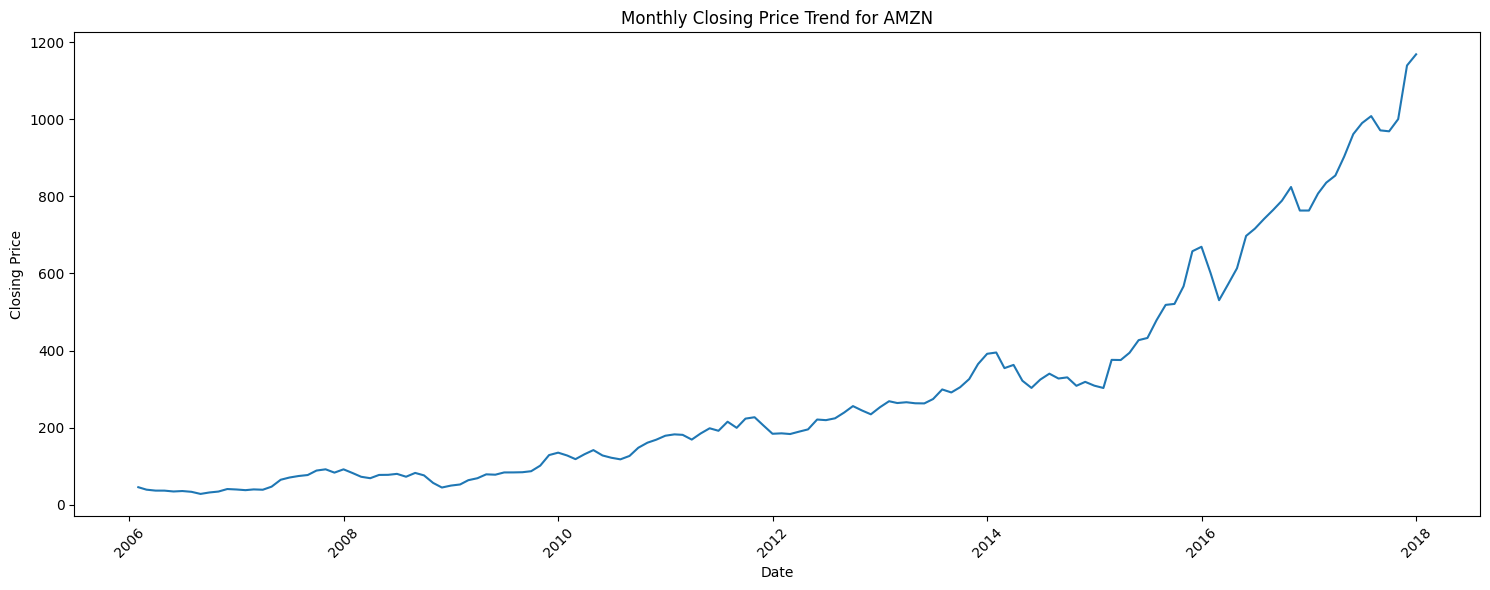

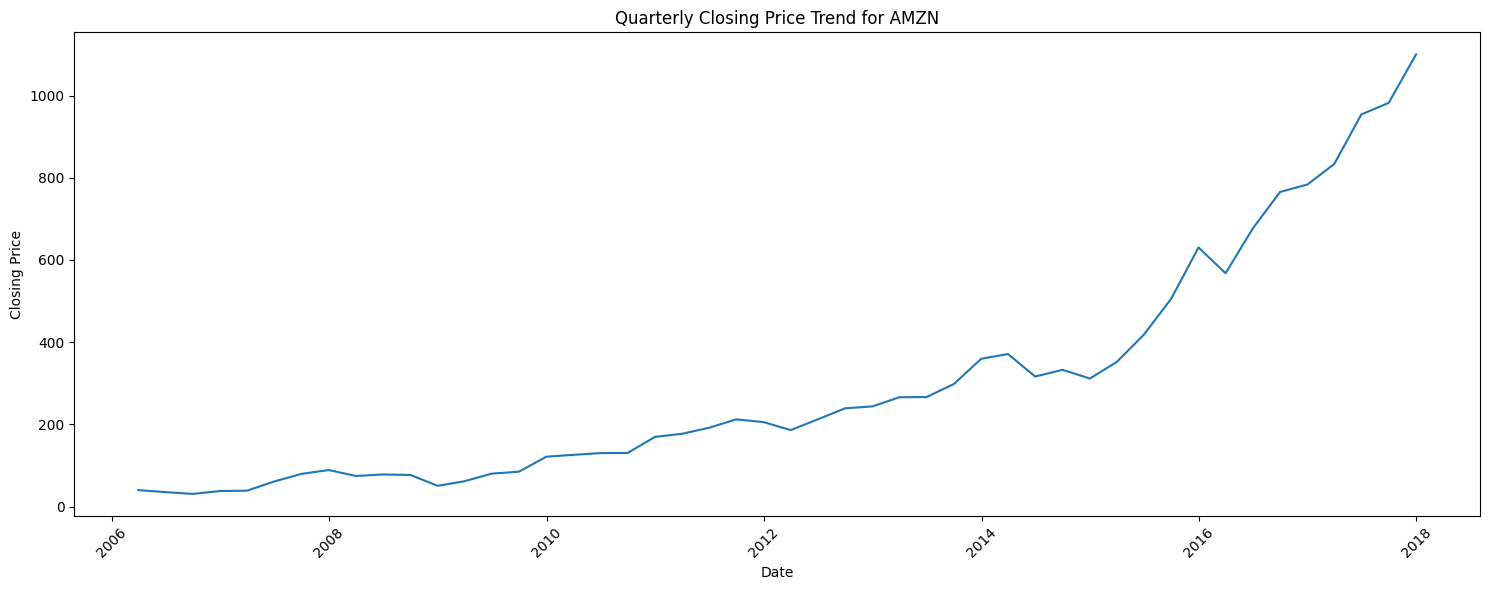

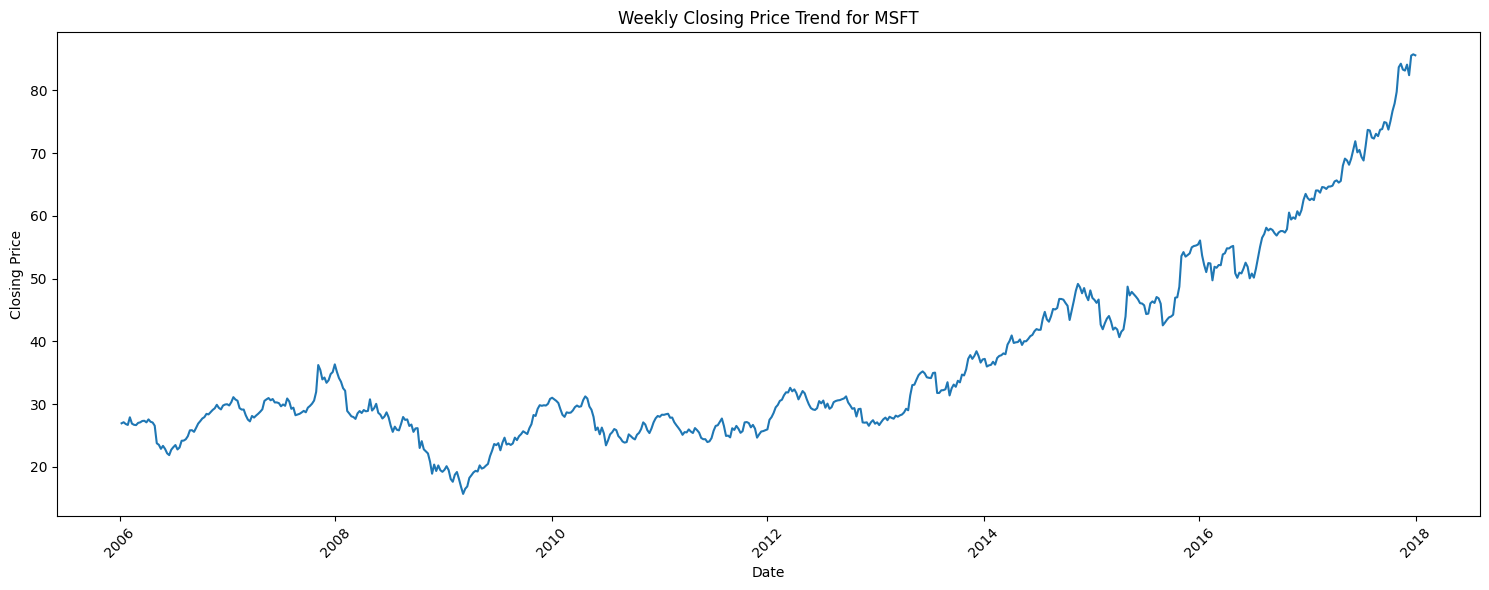

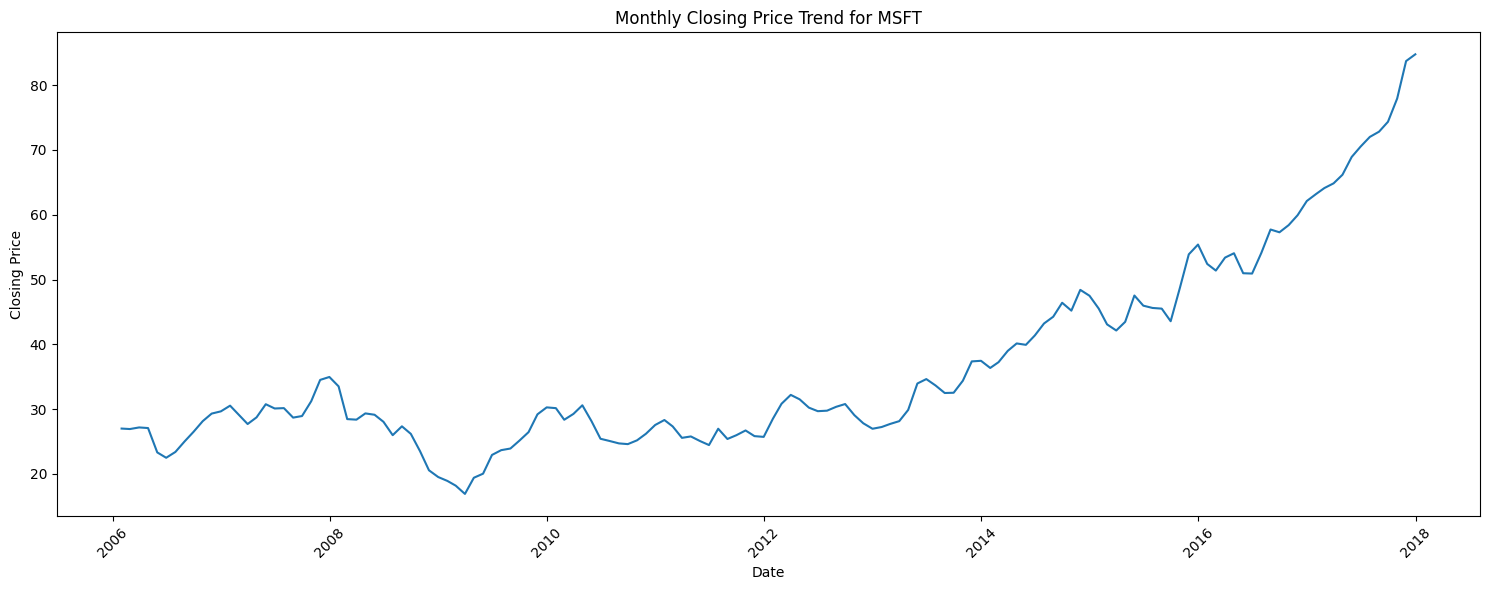

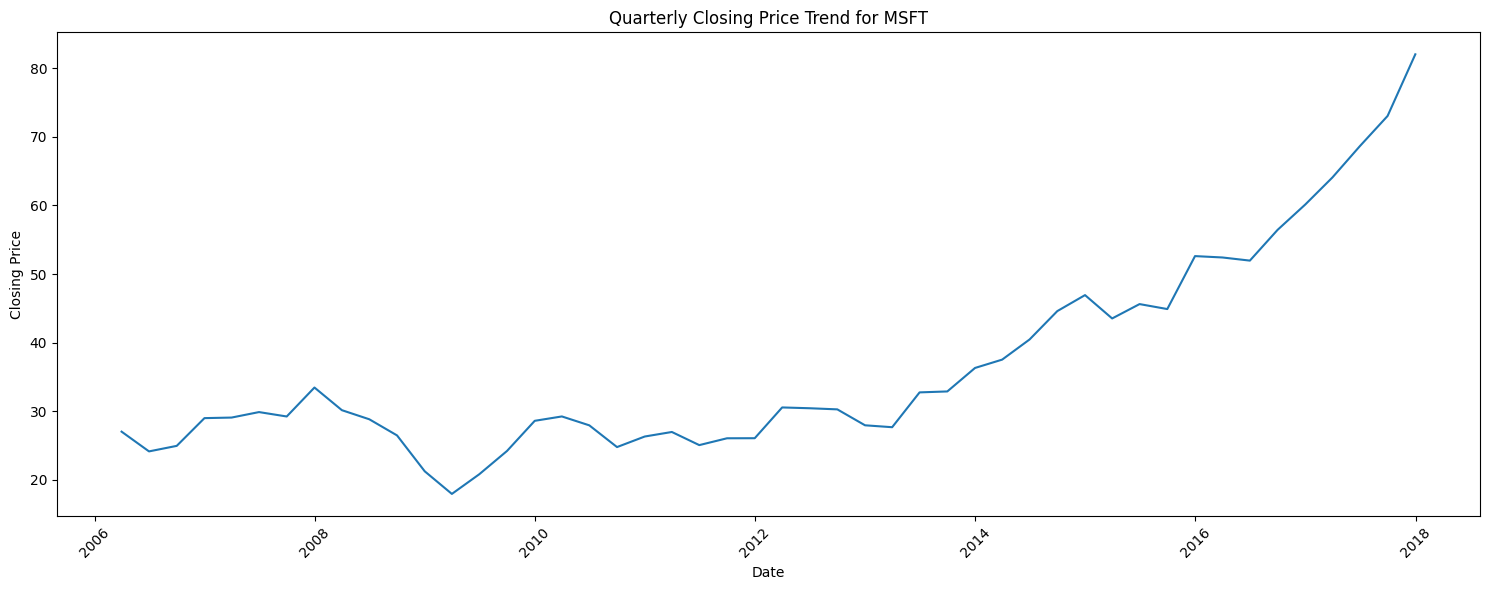

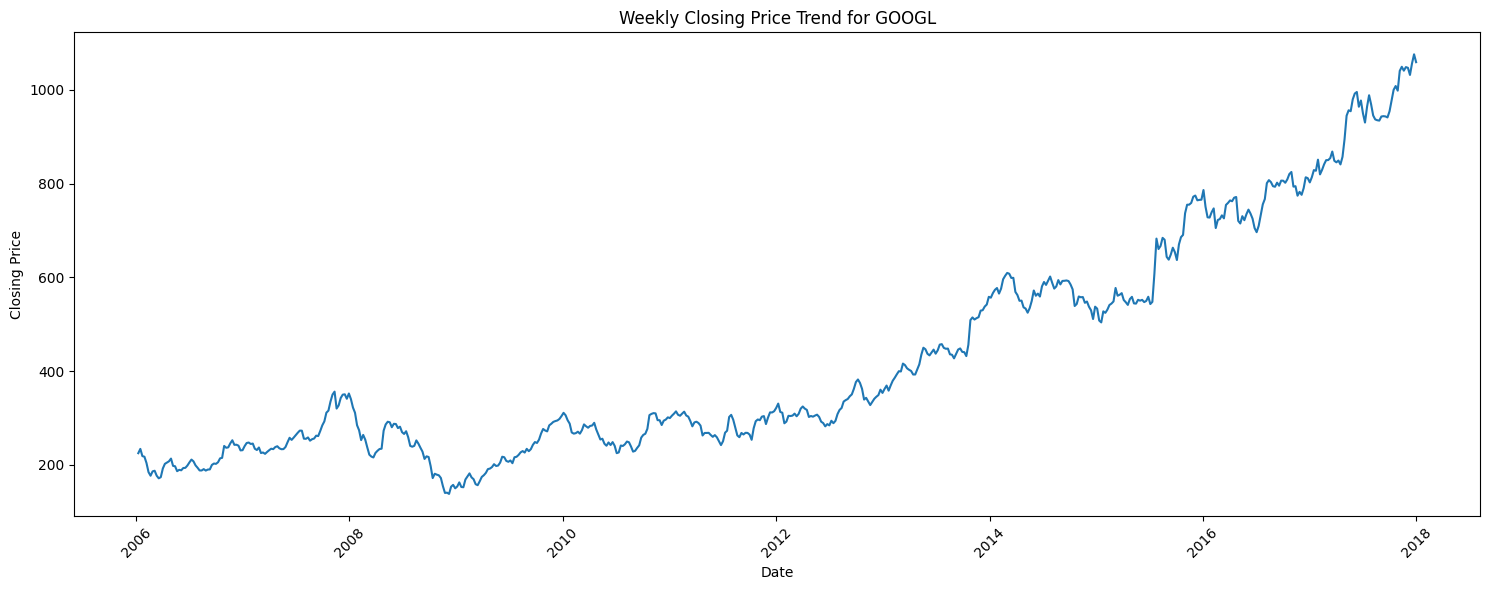

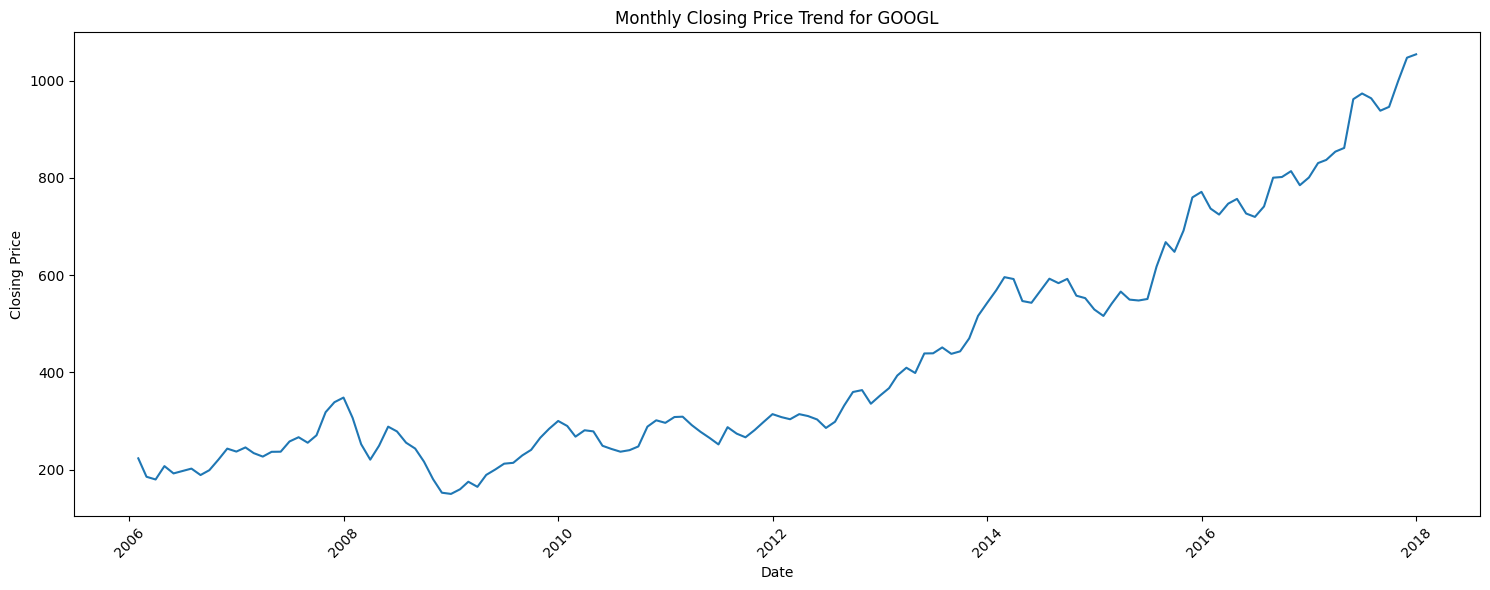

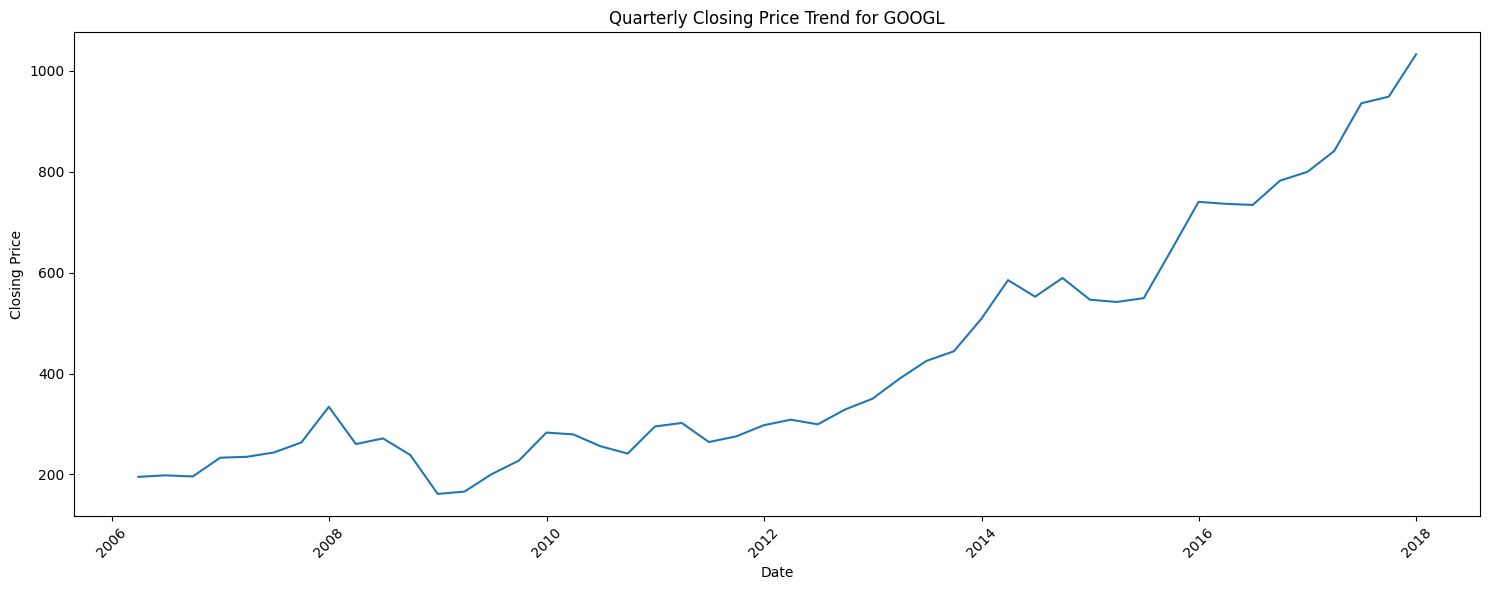

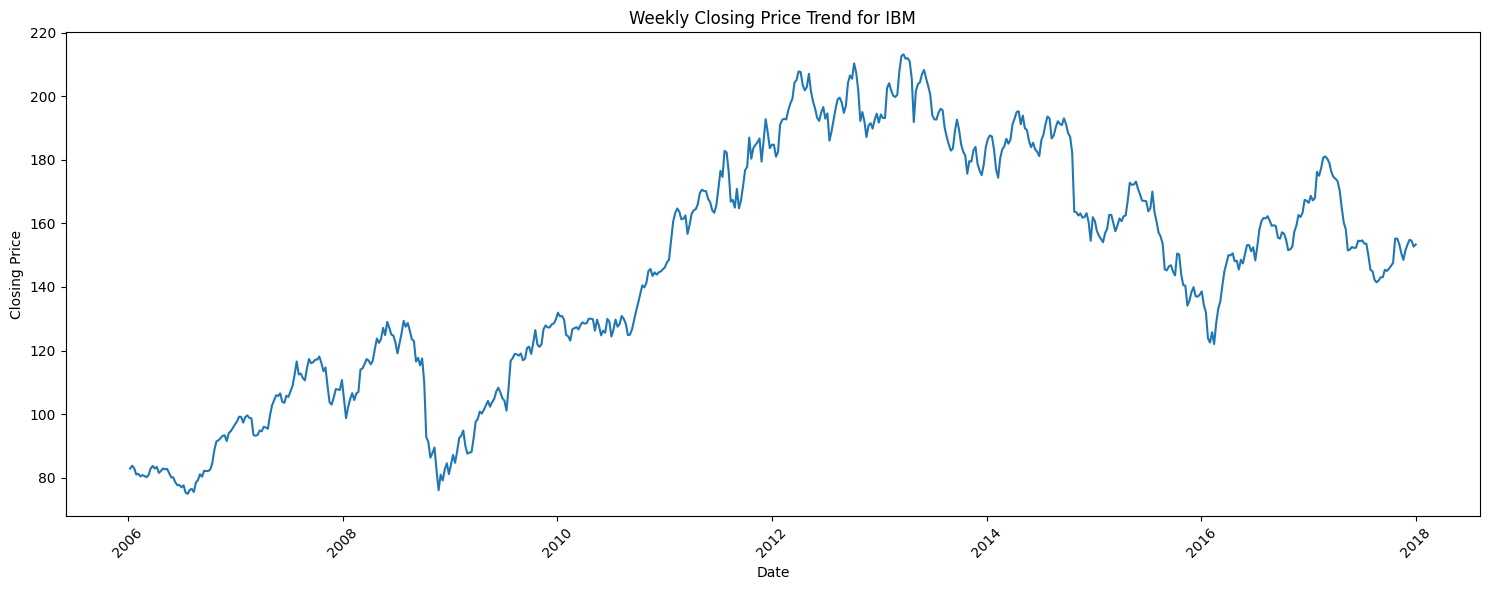

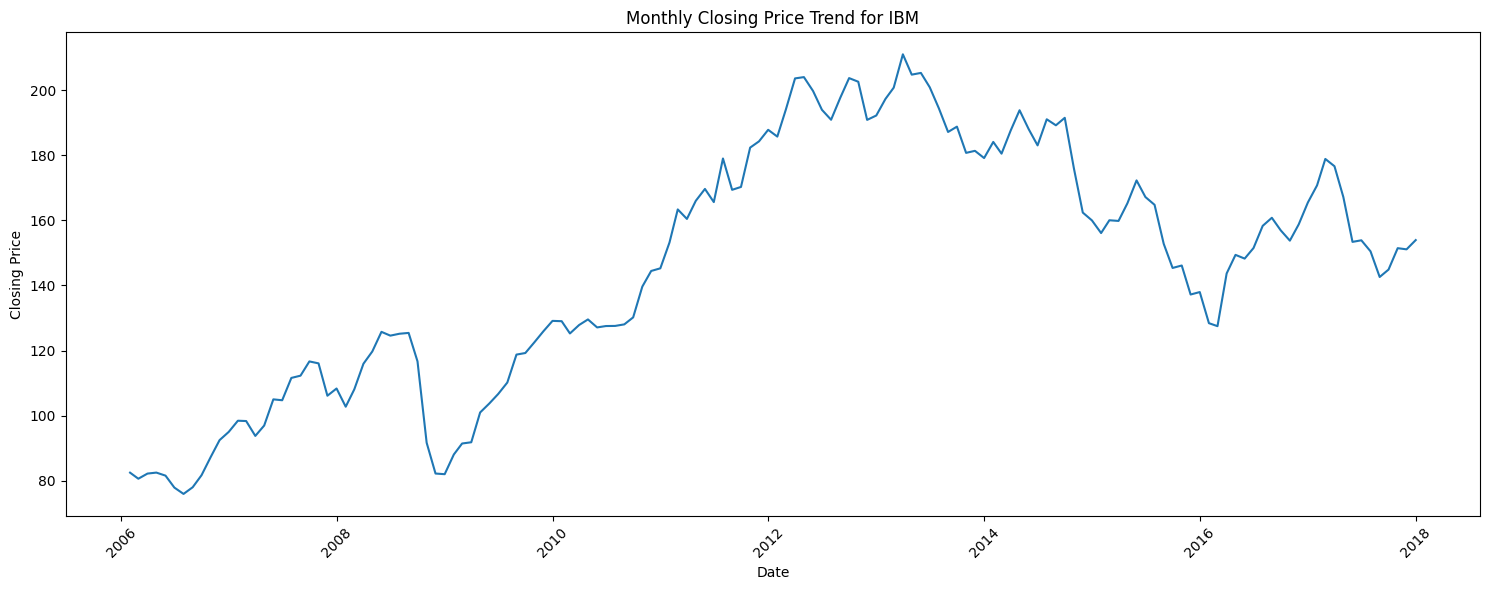

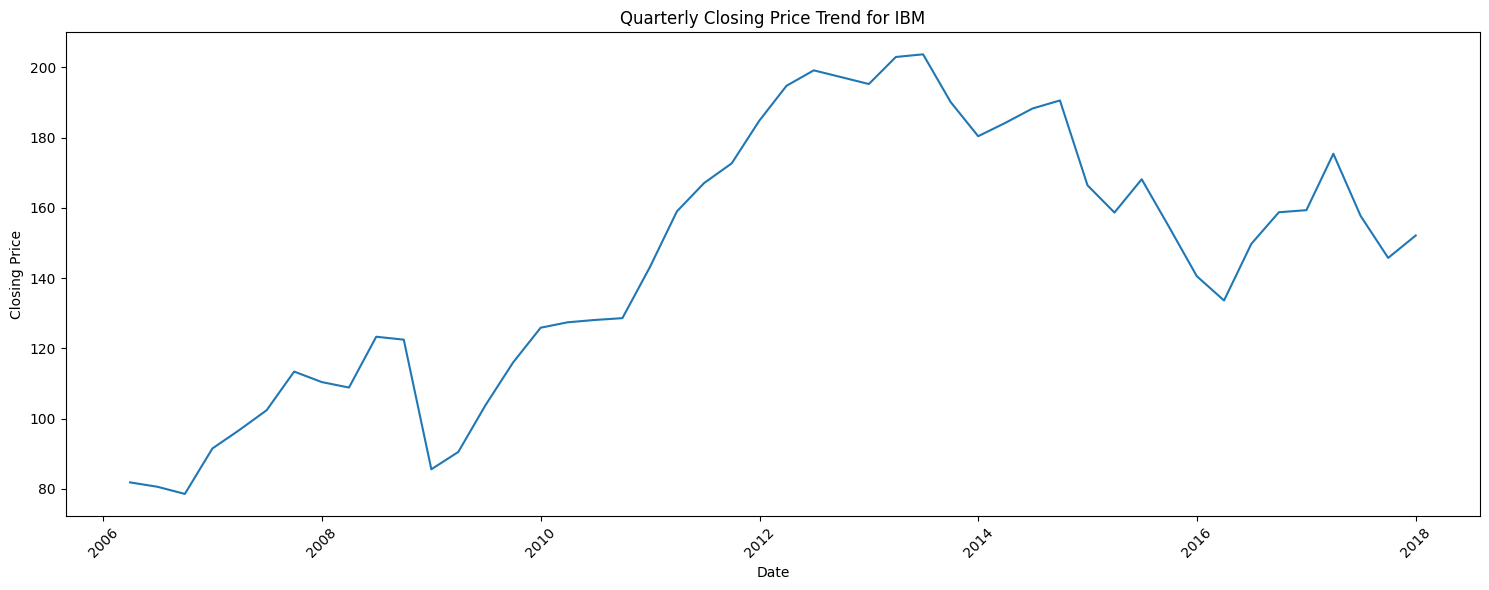

In [57]:
# Checking for patterns in different sequence lengths
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_names = stock_data['Name'].unique()

# Define the time frequencies you want to visualize
time_frequencies = {'Weekly': 'W', 'Monthly': 'M', 'Quarterly': 'Q'}

for name in stock_names:
    subset_data = stock_data[stock_data['Name'] == name].sort_values(by='Date')

    for freq_name, freq_code in time_frequencies.items():
        # Resample the data to the specified frequency (e.g., take the mean close price for the period)
        # You can choose other aggregation methods like 'first', 'last', 'ohlc'
        resampled_data = subset_data.set_index('Date')['Close'].resample(freq_code).mean().reset_index()

        plt.figure(figsize=(15, 6))
        sns.lineplot(data=resampled_data, x='Date', y='Close')
        plt.title(f'{freq_name} Closing Price Trend for {name}')
        plt.xlabel('Date')
        plt.ylabel('Closing Price')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [58]:
# Create data instances from the master data frame using decided window size and window stride
data = stock_data.copy()

config_input_dict = {
    'feature_cols': ['Open', 'High', 'Low', 'Volume'],
    'target_cols': 'Close',
    'target_names': stock_data['Name'].unique(),
    'window_size': 21,
    'stride': 1,
    'test_size': 0.3,
    'random_state': 42
}
X_train, y_train, X_test, y_test = prepare_stock_data_for_rnn(data, config_input_dict)

In [59]:
# Check the number of data points generated
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (8438, 21, 4)
y_train shape: (8438, 4)
X_test shape: (3617, 21, 4)
y_test shape: (3617, 4)


**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [60]:
# Check if the datasets are compatible inputs to neural networks
print("X_train dtype:", X_train.dtype)
print("y_train dtype:", y_train.dtype)

X_train dtype: float64
y_train dtype: float64


## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [61]:
# Create a function that creates a simple RNN model according to the model configuration arguments
def build_simple_rnn_model(input_config):
  # define parameters
  n_output = input_config['n_output']
  output_activation = input_config['activation']
  n_cells = input_config['n_cells']
  time_steps = input_config['time_steps']
  features = input_config['n_features']
  optimizer = tf.keras.optimizers.Adam(learning_rate=input_config['adam_learning_rate'])
  loss = input_config['loss']
  metrics = input_config['metrics']

  # instantiate sequential model
  model = Sequential()

  # the first hidden layer
  model.add(SimpleRNN(n_cells, input_shape=(time_steps, features)))

  # add output layer
  model.add(Dense(n_output, activation=output_activation))

  # Compile the model
  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

  return model


In [62]:
# write the code to run the model
model_input_config = {
    'n_cells': 100,
    'time_steps': X_train.shape[1],
    'activation': 'softmax',
    'adam_learning_rate': 0.0001,
    'loss': 'categorical_crossentropy',
    'metrics': ['accuracy'],
    'n_features': X_train.shape[2],
    'n_output': y_train.shape[1]
}
simpleRnn = build_simple_rnn_model(model_input_config)
# summarize defined model
simpleRnn.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_5 (SimpleRNN)        │ (None, 100)            │        10,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           404 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,904 (42.59 KB)

 Trainable params: 10,904 (42.59 KB)

 Non-trainable params: 0 (0.00 B)

In [63]:
# fit the model with x train & y train
simpleRnn.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2012 - loss: 0.6524
Epoch 2/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 0.6490
Epoch 3/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 0.6568
Epoch 4/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 0.6392
Epoch 5/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 0.6521
Epoch 6/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 0.6561
Epoch 7/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 1.0000 - loss: 0.6530
Epoch 8/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 0.6525
Epoch 9/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 0.6585
Epoch 10/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 0.6423


#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [64]:
# Find an optimal configuration of simple RNN
# Define the model-building function for Keras Tuner
def build_simple_rnn_model_tuner(hp):
    model = Sequential()

    # Tune the number of SimpleRNN units
    hp_units = hp.Int('rnn_units', min_value=32, max_value=256, step=32)
    model.add(SimpleRNN(units=hp_units, input_shape=(X_train.shape[1], X_train.shape[2])))

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)

    # Output layer (assuming regression for stock price prediction)
    model.add(Dense(y_train.shape[1], activation='softmax'))

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Set up the tuner (Hyperband is a good strategy)
tuner = kt.Hyperband(build_simple_rnn_model_tuner,
                     objective='val_accuracy',  # Metric to optimize during tuning (minimize validation MAE)
                     max_epochs=10,        # Maximum number of epochs to train a model in Hyperband
                     factor=3,             # Factor by which the number of epochs is reduced and models are increased
                     directory='rnn_tuning_dir', # Directory to save tuning results
                     project_name='rnn_stock_prediction')

# Define early stopping callback for the tuning process
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Run the hyperparameter search
print("Starting hyperparameter tuning...")
tuner.search(X_train, y_train, epochs=50, validation_split=0.3, callbacks=[stop_early])
print("Hyperparameter tuning finished.")

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]



Reloading Tuner from rnn_tuning_dir/rnn_stock_prediction/tuner0.json
Starting hyperparameter tuning...
Hyperparameter tuning finished.


In [65]:
# Find the best configuration based on evaluation metrics
print(f"""
The optimal number of RNN units is {best_hps.get('rnn_units')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")


The optimal number of RNN units is 32.
The optimal learning rate for the optimizer is 0.01.



#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

In [66]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model
# Get the best model
optimal_rnn_model = tuner.get_best_models(num_models=1)[0]
history = optimal_rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.3)

Epoch 1/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 1.0000 - loss: 0.5137 - val_accuracy: 1.0000 - val_loss: 1.0098
Epoch 2/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 1.0000 - loss: 0.5067 - val_accuracy: 1.0000 - val_loss: 1.0074
Epoch 3/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 0.5063 - val_accuracy: 1.0000 - val_loss: 1.0089
Epoch 4/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 0.5151 - val_accuracy: 1.0000 - val_loss: 1.0081
Epoch 5/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 0.5157 - val_accuracy: 1.0000 - val_loss: 1.0074
Epoch 6/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 0.5068 - val_accuracy: 1.0000 - val_loss: 1.0079
Epoch 7/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 0.4987 - val_accuracy: 1.0000 - val_loss: 1.0064
Epoch 8/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 0.5168 - val_accuracy: 1.

Plotting the actual vs predicted values

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


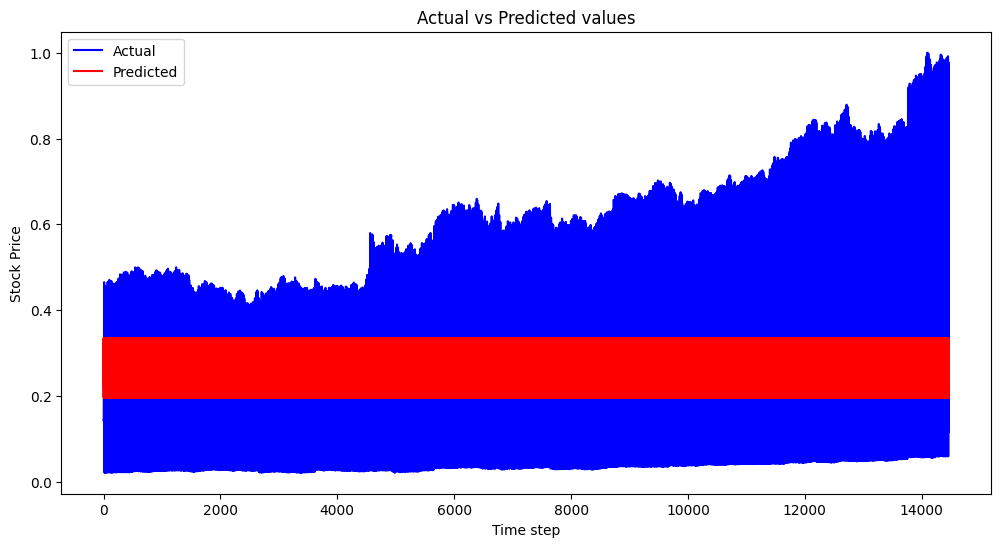

In [67]:
# Predict on the test data and plot
y_pred = optimal_rnn_model.predict(X_test)

# plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test.flatten(), label='Actual', color='blue')
plt.plot(y_pred.flatten(), label='Predicted', color='red')
plt.title('Actual vs Predicted values')
plt.xlabel('Time step')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [68]:
# Compute the performance of the model on the testing data set

test_loss, test_mae = optimal_rnn_model.evaluate(X_test, y_test, verbose=0) # Use verbose=0 to suppress progress bar

print(f"Test Mean Squared Error (MSE): {test_loss:.4f}")
print(f"Test Mean Absolute Error (MAE): {test_mae:.4f}")

Test Mean Squared Error (MSE): 1.8387
Test Mean Absolute Error (MAE): 1.0000


### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [69]:
# # Define a function to create a model and specify default values for hyperparameters
def bulid_advanced_rnn(model_type='LSTM',
                       input_shape=(10,4),
                       units=64,
                       num_layers=1,
                       dropout_rate=0.2,
                       learning_rate=0.001,
                       output_dim=1):
  model = Sequential()
  RNNLayer = LSTM if model_type == 'LSTM' else GRU

  # ADD RNN layers
  for i in range(num_layers):
    return_sequences = i < num_layers - 1
    if i == 0:
      model.add(RNNLayer(units, return_sequences=return_sequences, input_shape=input_shape))
    else:
      model.add(RNNLayer(units, return_sequences=return_sequences))
    model.add(dropout(dropout_rate))

    # output layer
    model.add(Dense(output_dim))

    # compile model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

    return model



#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [70]:
# Find an optimal configuration
def build_model(hp):
    model = Sequential()

    # choose model type
    rnn_type = hp.Choice('rnn_type', ['LSTM', 'GRU'])
    RNNLayer = LSTM if rnn_type == 'LSTM' else GRU

    # add rnn layer
    model.add(RNNLayer(units=hp.Int('ubits', 32, 128, step=32),
                       input_shape=X_train.shape[1:]))

    # add dropout
    model.add(dropout(hp.float('dropout', 0.1, 0.5, step=0.1)))

    # output layer
    model.add(dense(y_train.shape[1]))

    #compile
    model.compile(optimizer=Adem(learning_rate=hp.float('lr', 1e-4, 1e-2, sampling='log')),
                    loss='mse',
                    metrics=['mae'])
    return model

    #Run tuner
    tuner = kt.RandomSearch(
        build_model,
        objective='val_loss',
        max_trails=5,
        executions_per_trail=1,
        directory='tuning_dir',
        project_name='simple_rnn_tune'
    )
tuner.search(X_train, y_train, epochs=10, validation_split=0.2)

# to get best model
best_model = tuner.get_best_models(1)[0]

#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [71]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model

# retrieve best hyperparameters
best_hps = tuner.get_best_hyperparameters(1)[0]

# build the model using best hyperparameters
model = tuner.hypermodel.build(best_hps)

# train the final model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

#Evaluate on test data
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")



Epoch 1/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9009 - loss: 0.5507 - val_accuracy: 1.0000 - val_loss: 1.1064
Epoch 2/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 0.5524 - val_accuracy: 1.0000 - val_loss: 1.1065
Epoch 3/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 0.5474 - val_accuracy: 1.0000 - val_loss: 1.1062
Epoch 4/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 0.5445 - val_accuracy: 1.0000 - val_loss: 1.1051
Epoch 5/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 0.5496 - val_accuracy: 1.0000 - val_loss: 1.1065
Epoch 6/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 0.5474 - val_accuracy: 1.0000 - val_loss: 1.1094
Epoch 7/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 0.5466 - val_accuracy: 1.0000 - val_loss: 1.1057
Epoch 8/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 0.5508 - val_accuracy: 1.

In [72]:
# Compute the performance of the model on the testing data set

# Evaluate the final trained model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)

print(f"Test Mean Squared Error (MSE): {test_loss:.4f}")
print(f"Tes Mean Absolute Error (MAE): {test_mae:.4f}")

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.4723
Test Mean Squared Error (MSE): 1.8435
Tes Mean Absolute Error (MAE): 1.0000


Plotting the actual vs predicted values

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


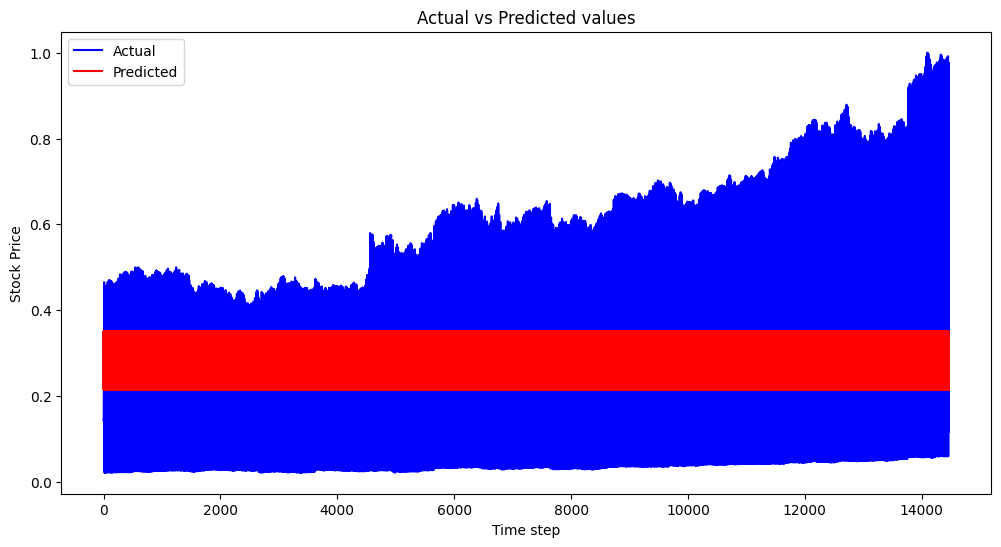

In [73]:
# Predict on the test data

# predict on the test data
y_pred= model.predict(X_test)

# plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test.flatten(), label='Actual', color='blue')
plt.plot(y_pred.flatten(), label='Predicted', color='red')
plt.title('Actual vs Predicted values')
plt.xlabel('Time step')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [74]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter



In [75]:
# Check the number of data points generated



### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [76]:
# Find an optimal configuration of simple RNN



In [77]:
# Find the best configuration



In [78]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the



In [79]:
# Compute the performance of the model on the testing data set



In [80]:
# Plotting the actual vs predicted values for all targets



#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [81]:
# Find an optimal configuration of advanced RNN



In [82]:
# Find the best configuration



In [83]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model



In [84]:
# Compute the performance of the model on the testing data set



In [85]:
# Plotting the actual vs predicted values for all targets



## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.